In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import requests

In [2]:
def open_jsons(metric):

    with open(f"nested_uncorrected_{metric}_future_projections.json") as f:
        uncorrected_data = json.load(f)
    with open(f"nested_bias_corrected_{metric}_future_projections.json") as f:
        corrected_data = json.load(f)

    return uncorrected_data, corrected_data

In [3]:
delta_ids = list(open_jsons("freezing_index")[0].keys())
communities = requests.get("https://earthmaps.io/places/communities").json()

delta_names = []
for k in delta_ids:
    for item in communities:
        if item["id"] == k:
            delta_names.append(item["name"])
delta_dict = dict(zip(delta_names, delta_ids))

delta_dict

{'Anchorage': 'AK15',
 'Bethel': 'AK36',
 'Bettles': 'AK37',
 'Cold Bay': 'AK85',
 'Cordova': 'AK89',
 'Eagle': 'AK102',
 'Fairbanks': 'AK124',
 'Gulkana': 'AK141',
 'Homer': 'AK152',
 'Juneau': 'AK172',
 'Kenai': 'AK188',
 'King Salmon': 'AK196',
 'Kodiak': 'AK205',
 'Kotzebue': 'AK211',
 'Matanuska': 'AK239',
 'McGrath': 'AK241',
 'Nome': 'AK280',
 'North Pole': 'AK283',
 'Port Alsworth': 'AK320',
 'Talkeetna': 'AK382',
 'Tanana': 'AK384',
 'Utqiaġvik': 'AK418',
 'Yakutat': 'AK435'}

In [4]:
def prep_df(snap_id, metric):

    reference, bc = open_jsons(metric)
    uncorrected_data = reference[snap_id]
    corrected_data = bc[snap_id]
    df = pd.DataFrame()

    for model in uncorrected_data.keys():
        if 'rcp85' in uncorrected_data[model].keys():
            uncorrected_df = pd.DataFrame.from_dict(uncorrected_data[model]["rcp85"], orient='index', columns=['dd'])
            uncorrected_df['year'] = uncorrected_df.index
            uncorrected_df['model'] = model
            # can add scenario category if using both rcps
            uncorrected_df['Bias Correction'] = 'None'

            corrected_df = pd.DataFrame.from_dict(corrected_data[model]["rcp85"], orient='index', columns=['dd'])
            corrected_df['year'] = corrected_df.index
            corrected_df['model'] = model
            #corrected_df['model'] = model
            corrected_df['Bias Correction'] = 'Delta to WRCC'

            # Concatenate the DataFrames
            df = pd.concat([df, uncorrected_df, corrected_df])

    # Convert the 'year' column to datetime
    df['year'] = pd.to_datetime(df['year'], format='%Y')

    return df

In [7]:
def make_plot(df, ylabel, title, place):
    sns.relplot(
        data=dd, kind="line",
        x="year", y="dd", hue="Bias Correction", height=5, aspect=1.8
    )

    plt.title(f"{place} {title}: NCAR 12km 9 Model Ensemble, RCP 8.5")
    plt.ylabel(f"{ylabel} (F*Days)")
    plt.show()

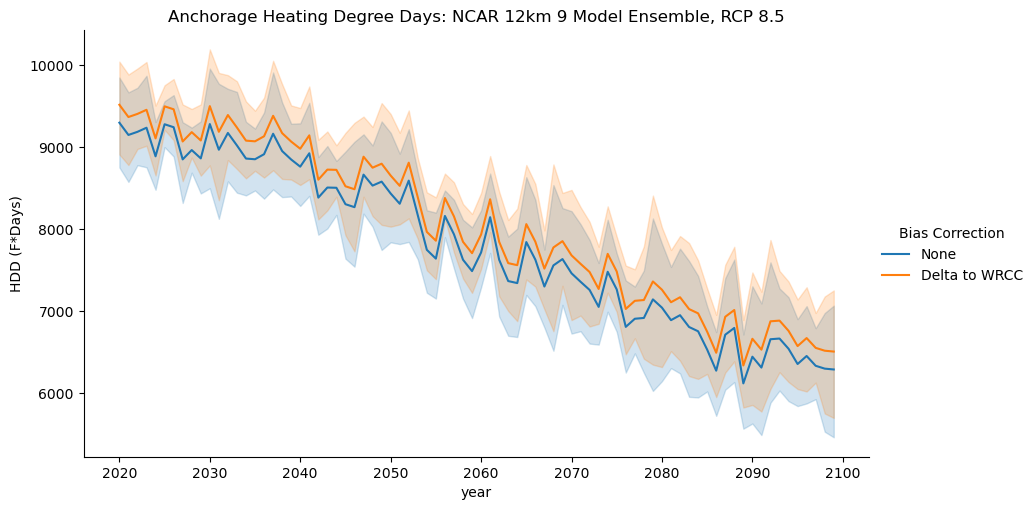

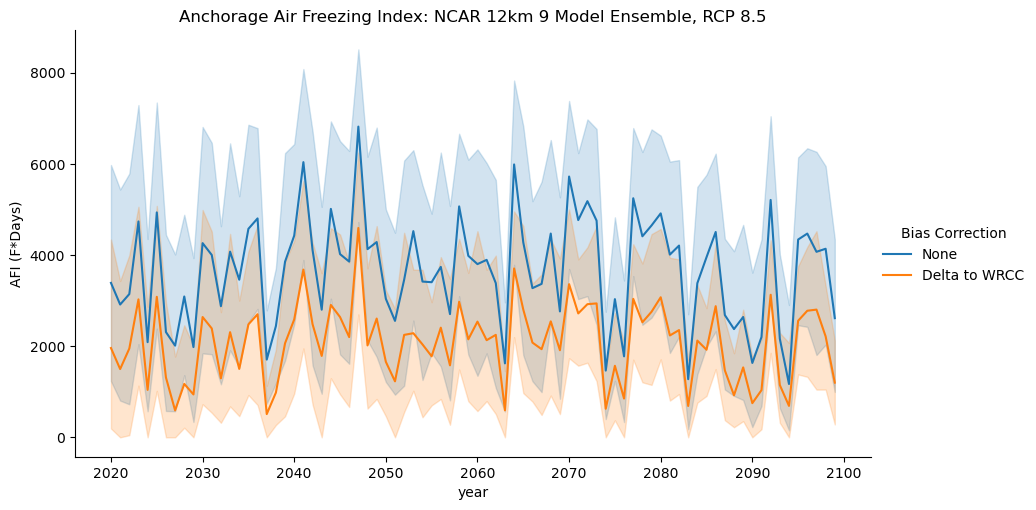

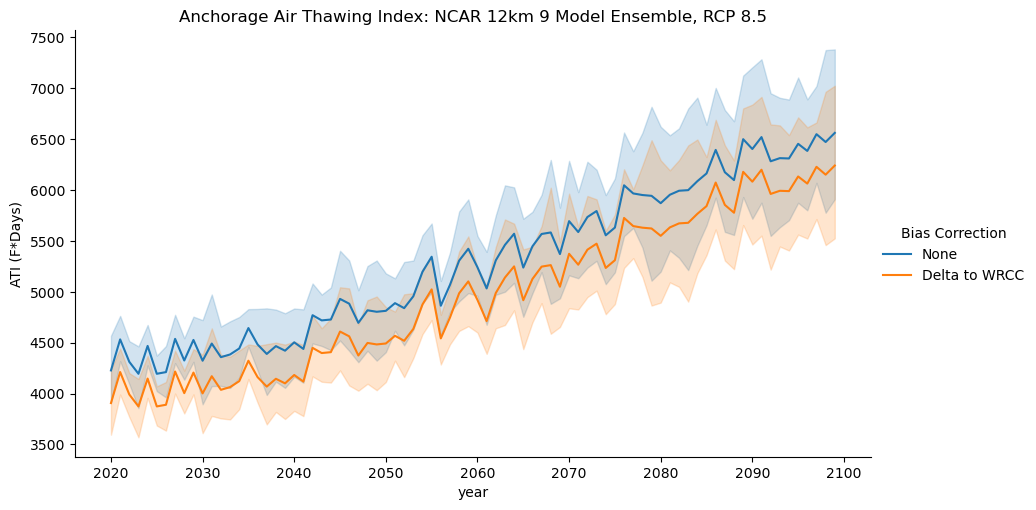

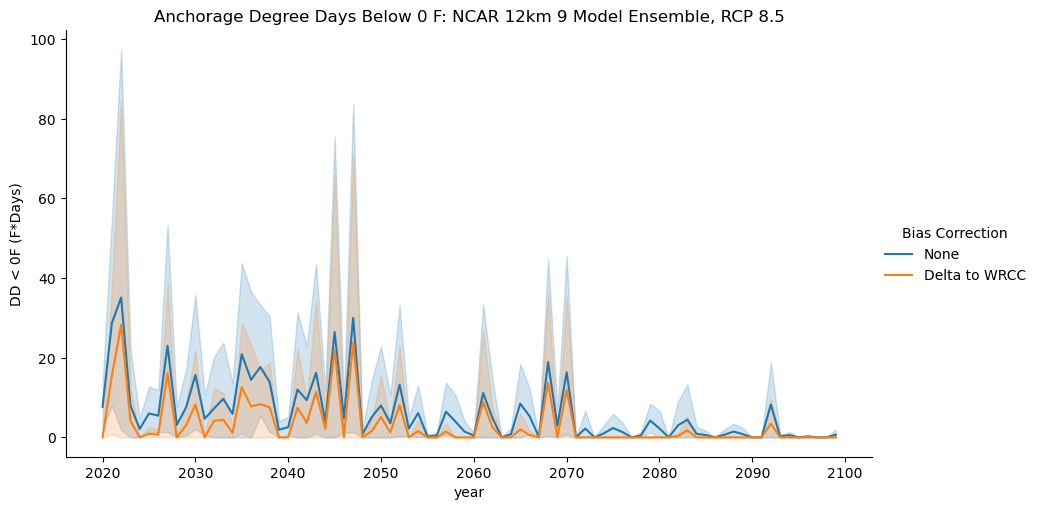

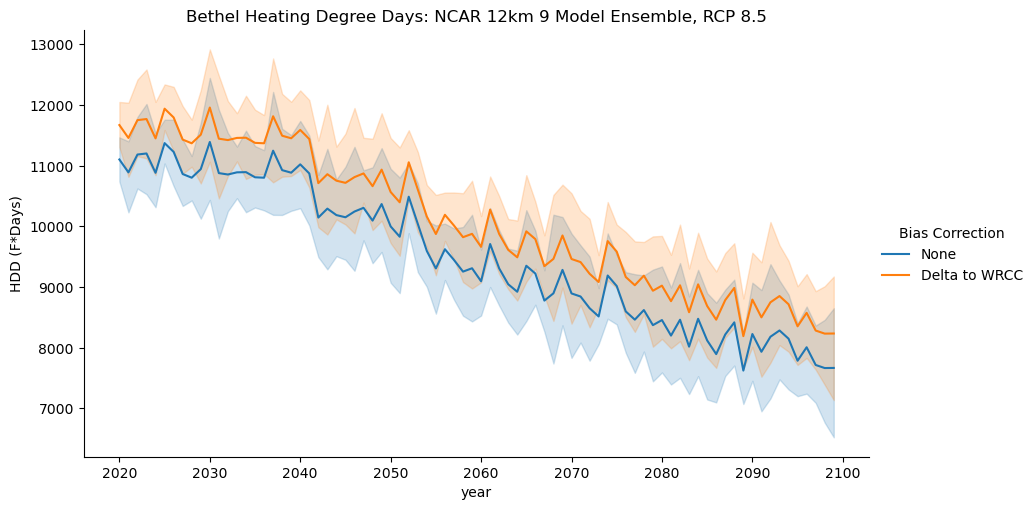

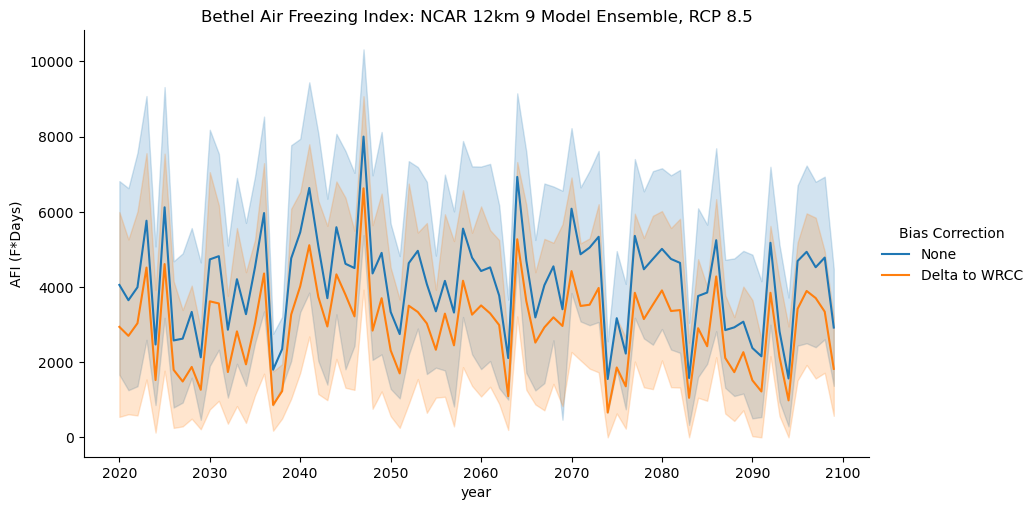

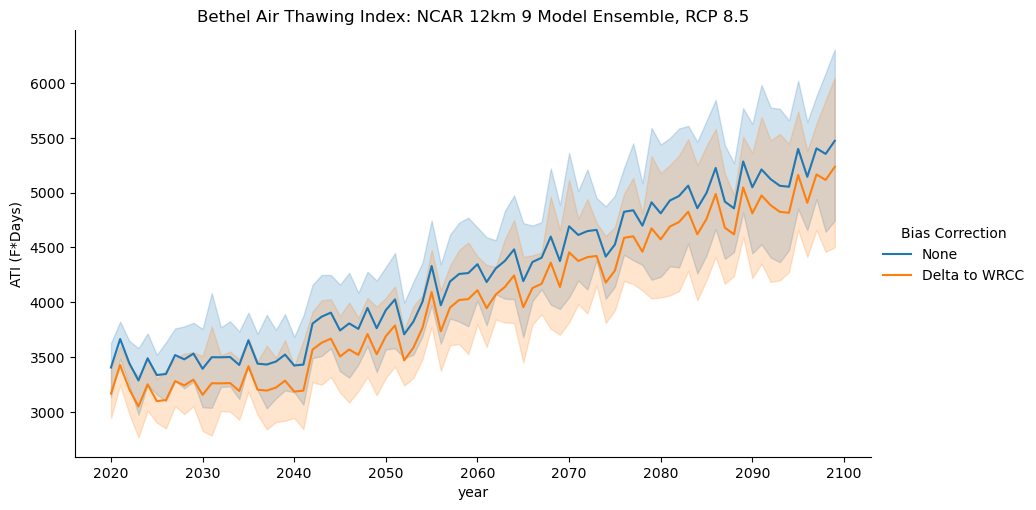

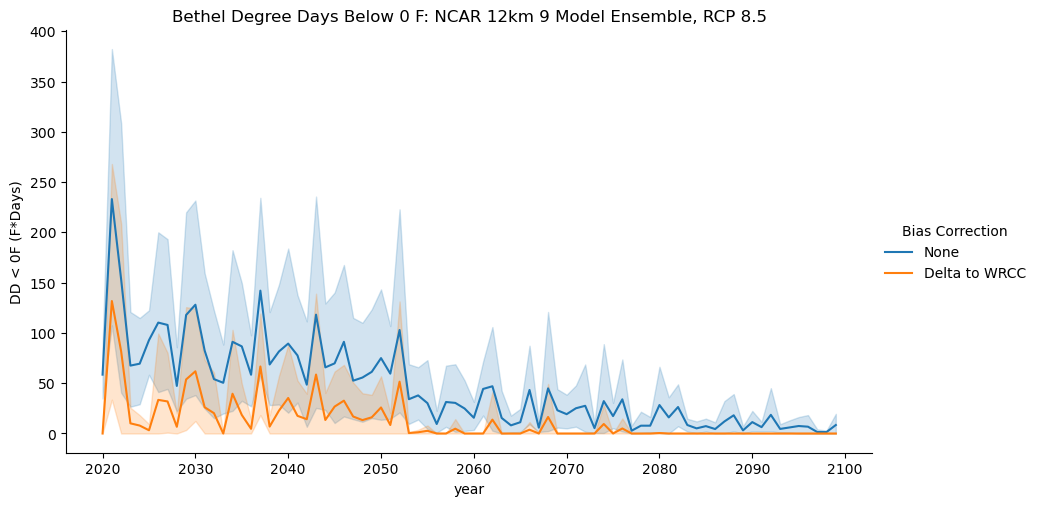

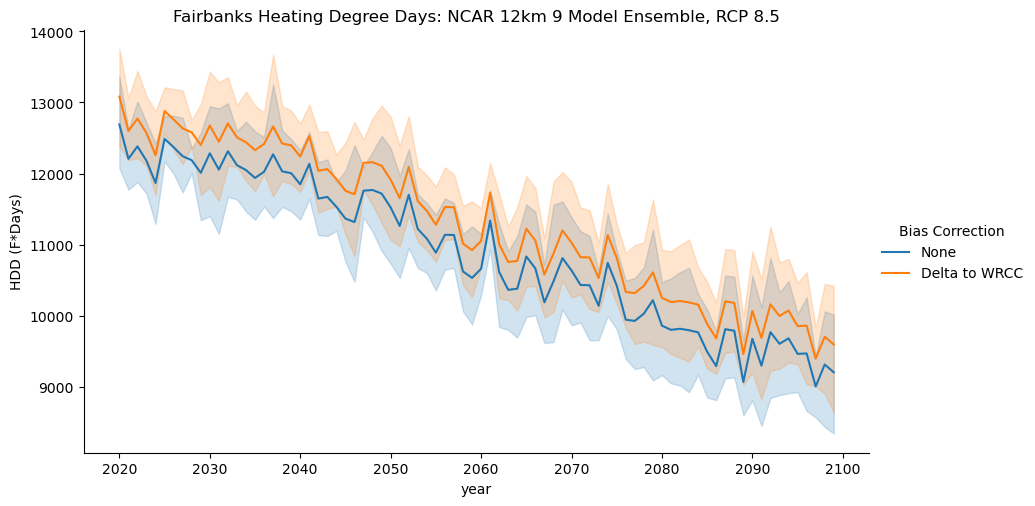

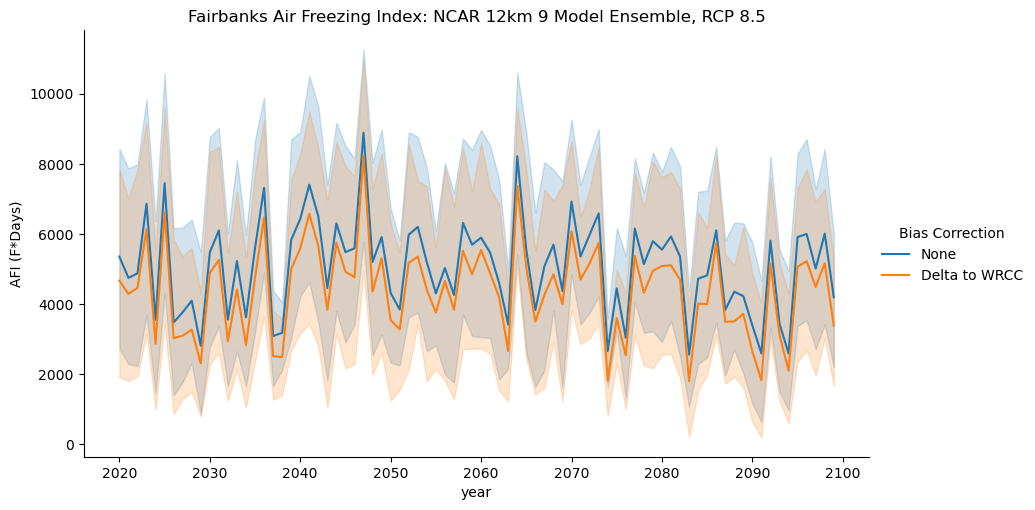

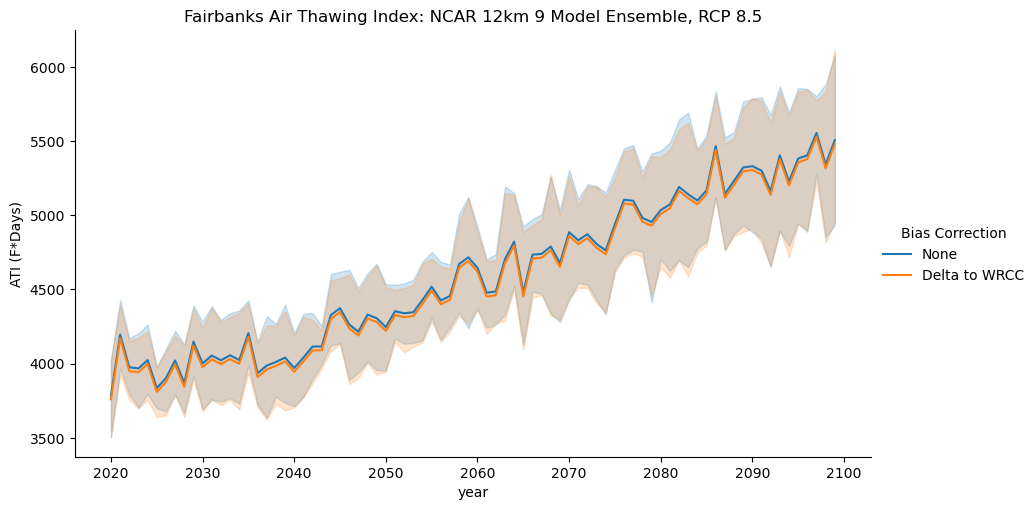

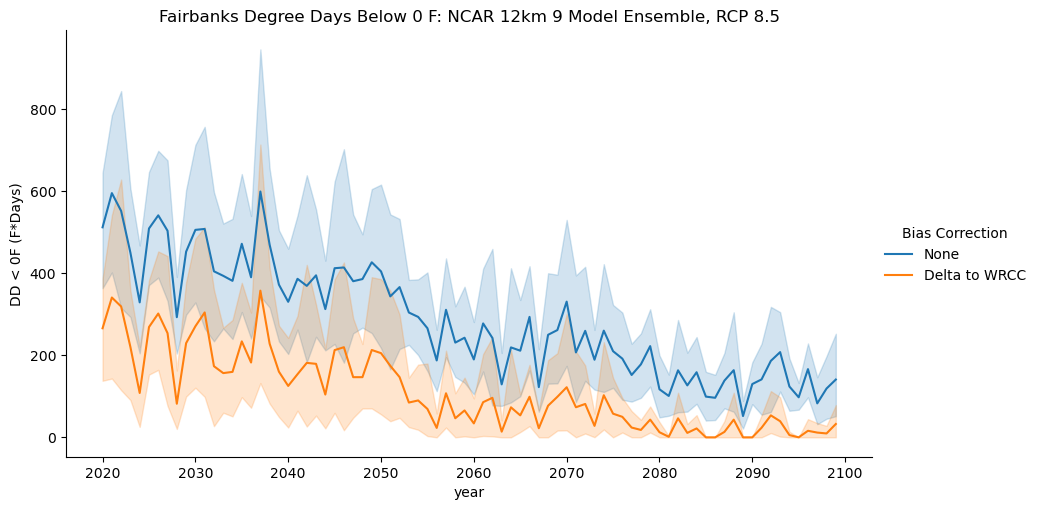

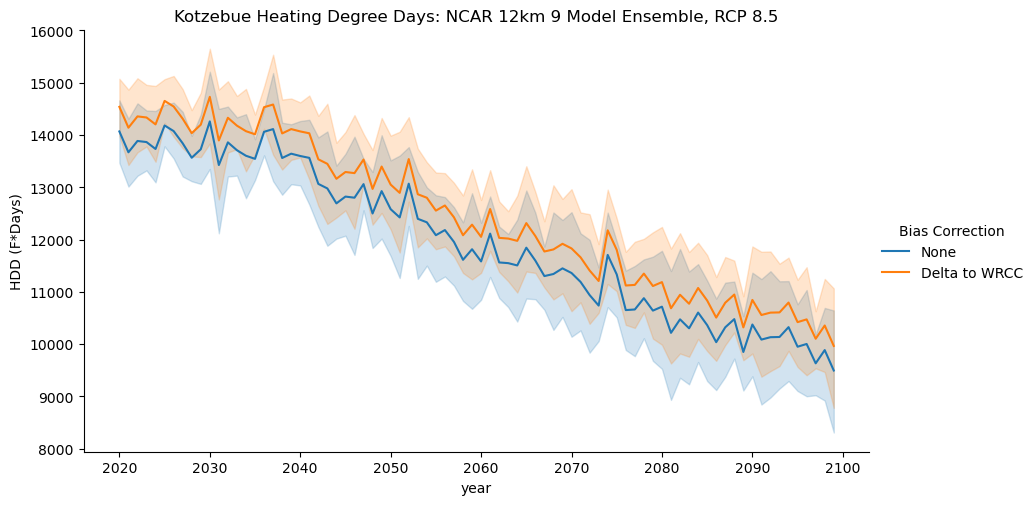

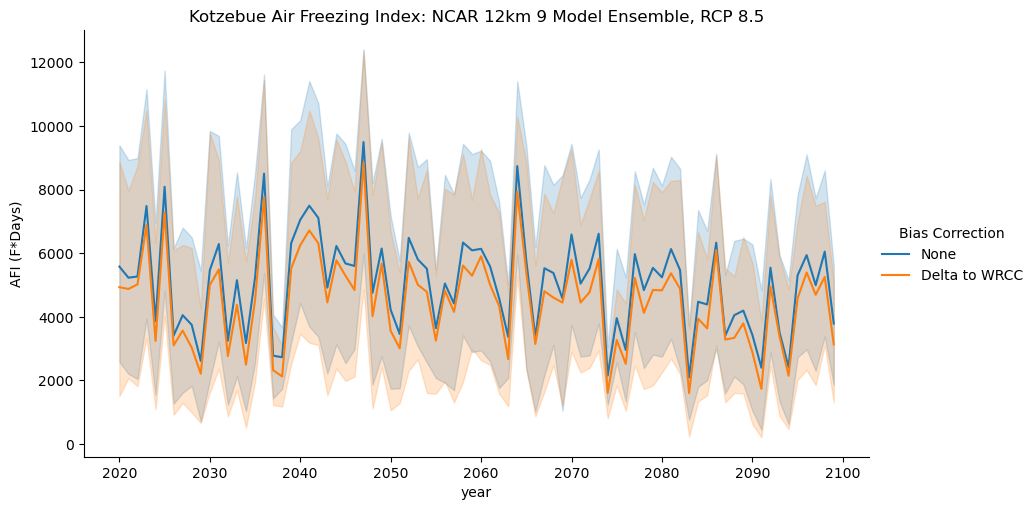

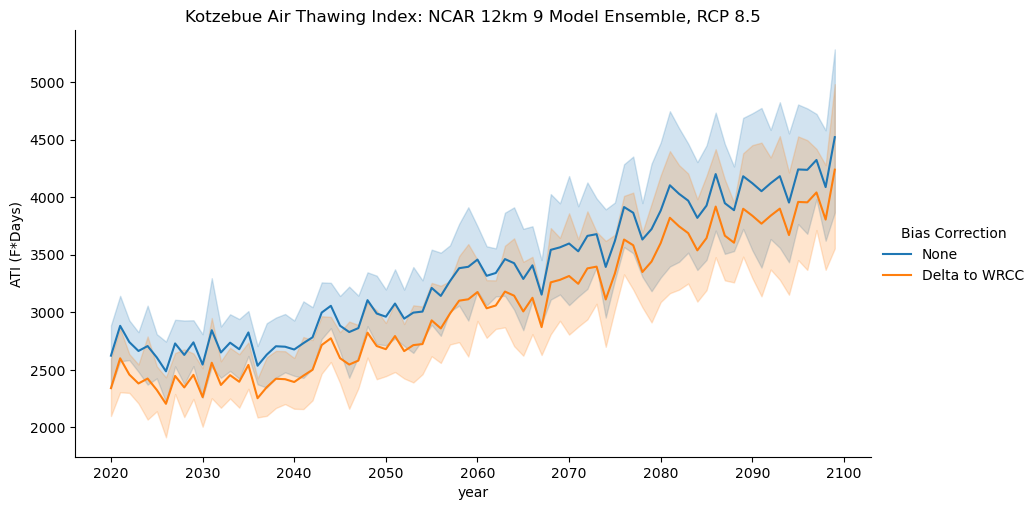

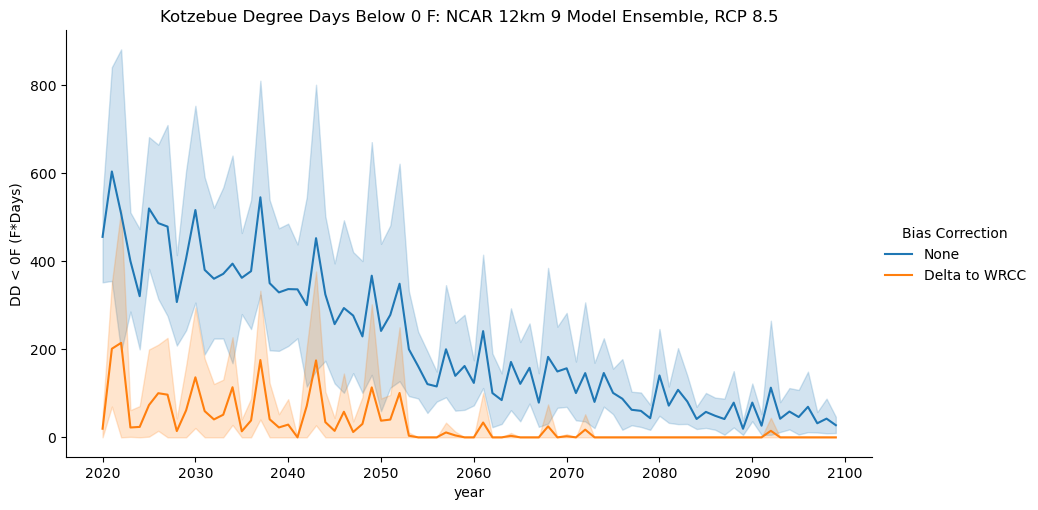

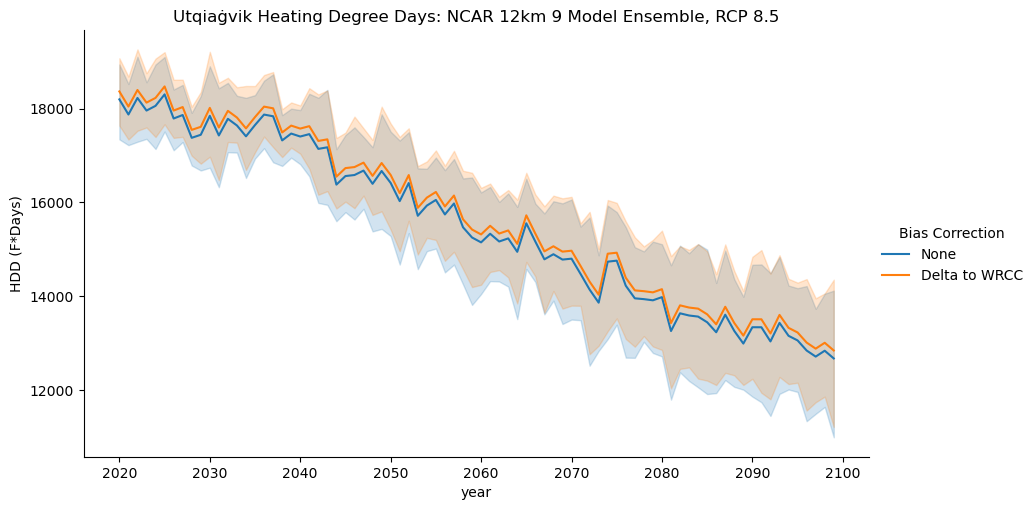

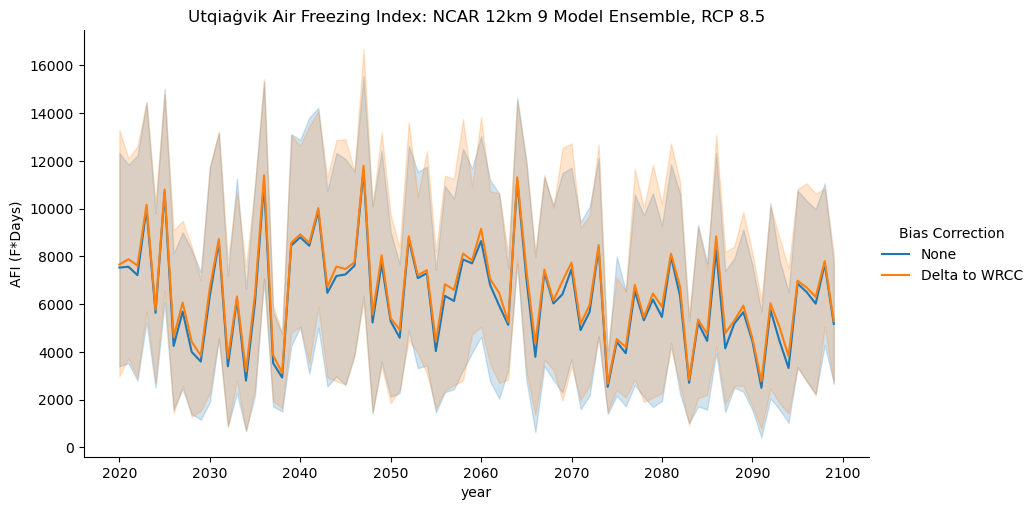

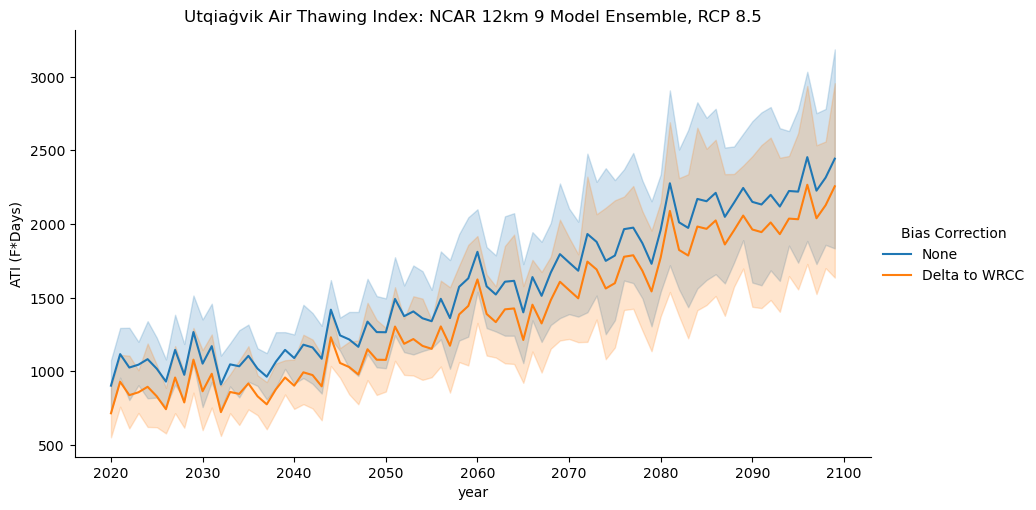

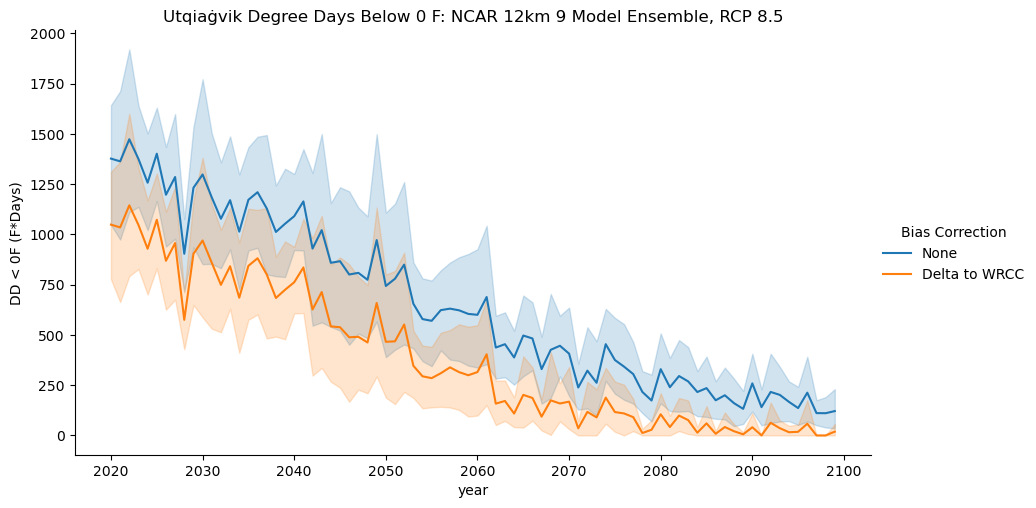

In [8]:
to_plot = ["Anchorage", "Bethel", "Fairbanks", "Kotzebue", "Utqiaġvik"]

metrics = ["heating", "freezing_index", "thawing_index", "below_zero"]
ys = ["HDD", "AFI", "ATI", "DD < 0F"]
ts = ["Heating Degree Days", "Air Freezing Index", "Air Thawing Index", "Degree Days Below 0 F"]

for location in to_plot:
    for m, y, t in zip(metrics, ys, ts):
        dd = prep_df(delta_dict[location], m)
        make_plot(dd, y, t, location)